### Convolutional Autoencoder

In [67]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D 

In [68]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            ]))
ds_test = torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize((img_size,img_size)),
                                torchvision.transforms.ToTensor(),
                                ]))
ds = torch.utils.data.Subset(ds_full, range(4096))

In [69]:
def Draw(x):
    with torch.no_grad():
        plt.imshow(x.squeeze().detach().numpy(), cmap='gray');
        plt.axis('off');

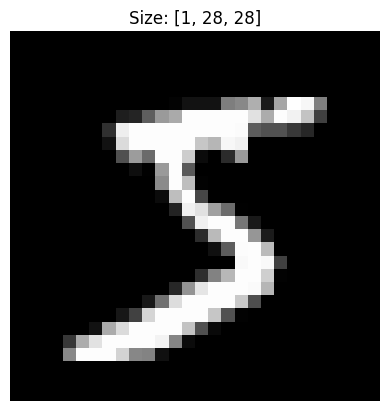

In [70]:
with torch.no_grad():
    x,t = ds.__getitem__(0)
    Draw(x)
    plt.title(f'Size: {list(x.size())}')
plt.show()

In [71]:
# Batched, for training
batch_size_train = 16
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=True)
# A single batch, for plotting
train_all = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)
x , t = ds.__getitem__(0)
print(x.size())
print(x)
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=256, shuffle=False)

torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

# Complete the ConvAE class

In [72]:
class ConvAE(nn.Module):
    def __init__(self, img_size=28, embedding_dim=3):
        self.img_size = img_size
        self.embedding_dim = embedding_dim
        self.losses = []
        super().__init__()
        
        # Hardcoded 128 instead of embedding_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), 
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),                       
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),                       
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Flatten(),                             
            nn.Linear(64 * 7 * 7, embedding_dim)                
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 64 * 7 * 7),               
            nn.ReLU(True),
            nn.Unflatten(1, (64, 7, 7)),              
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), 
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0), 
            nn.ReLU(True),
            nn.Conv2d(16, 1, kernel_size=3, padding=1), 
            nn.Sigmoid()                              
        )

    def encode(self, x):
        x = self.encoder(x)
        return x 
    
    def decode(self, x):
        x = self.decoder(x)
        return x 
  
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x 


# Create and Train the Model

100%|██████████| 100/100 [04:38<00:00,  2.79s/it]


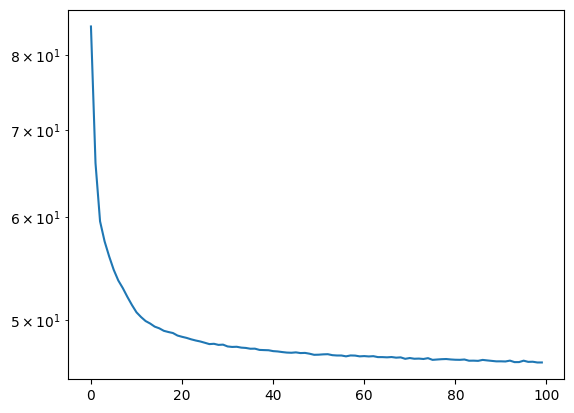

In [73]:
# Setup and Train
net = ConvAE(img_size=img_size, embedding_dim=3)
loss = nn.BCELoss()
optim = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

# Train it
for epoch in tqdm(range(100)):
    total_loss = 0.
    for x, y in train_dl:
        #print(x)
        xhat = net(x)
        l = loss(xhat, x)
        optim.zero_grad()
        for p in net.parameters():
            l += 0.0005*p.norm(2)
        total_loss += l.item()
        l.backward()
        optim.step()
    net.losses.append(total_loss)

fig3 = plt.figure()
plt.plot(net.losses);
plt.yscale('log');

# Plot the Hidden Layer

In [74]:
# Here are 10 colours you can use. But feel free to use others, too.
colour_options = ['k', 'tab:brown', 'r', 'orange', 'gold', 'lawngreen', 'forestgreen', 'blue', 'mediumpurple', 'gray']
for x, y in train_all:
    print("This loop only runs once to get the hidden layer and y's value")
    h = net.encode(x).detach().numpy()
    y_val = y.detach().numpy()
    y_hat = net(x)
print(h.shape)
print(y_val.shape)
#print(h[:,0])
print(h)
#print(h[:,2])
print(y_val)
print(net.losses[-1])

This loop only runs once to get the hidden layer and y's value
This loop only runs once to get the hidden layer and y's value
This loop only runs once to get the hidden layer and y's value
This loop only runs once to get the hidden layer and y's value
(1024, 3)
(1024,)
[[  7.220665   -11.179939   -17.667683  ]
 [ 12.719238    -2.299198    -4.958939  ]
 [ -1.4786143    0.81201035 -21.82414   ]
 ...
 [  0.07884648   3.8058608  -13.854494  ]
 [ 13.52544     -8.042334    -5.2351575 ]
 [  1.9873519    7.6942034  -19.447908  ]]
[4 8 4 ... 9 3 9]
46.38462649285793


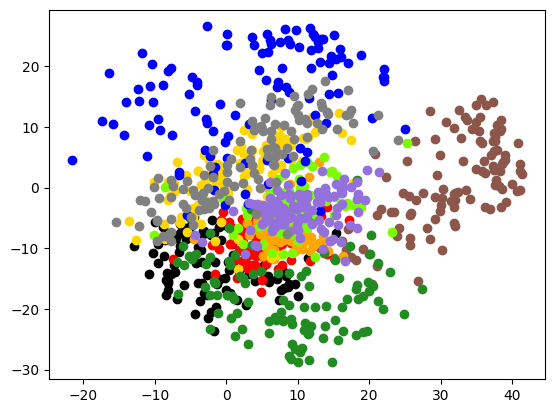

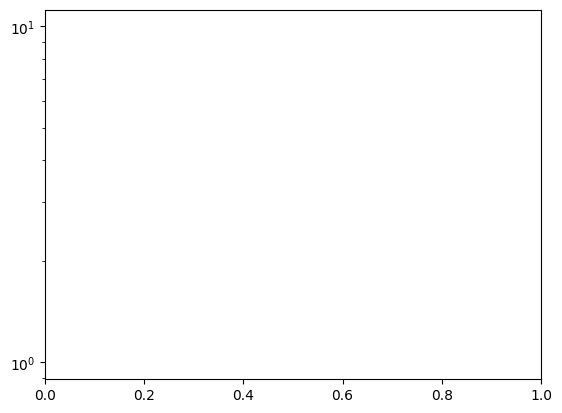

In [75]:
# You can create three 2D planar projections.
fig6 = plt.figure()

for i in range(10):
    class_indices = np.where(y_val == i)
    plt.scatter(h[class_indices,0], h[class_indices,1], color = colour_options[i], marker='o')
plt.show()
plt.yscale('log');


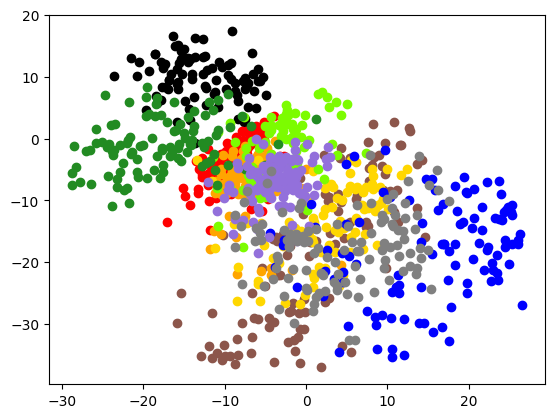

In [76]:
for i in range(10):
    class_indices = np.where(y_val == i)
    scatter = plt.scatter(h[class_indices,1], h[class_indices,2], color = colour_options[i], marker='o')
plt.show()

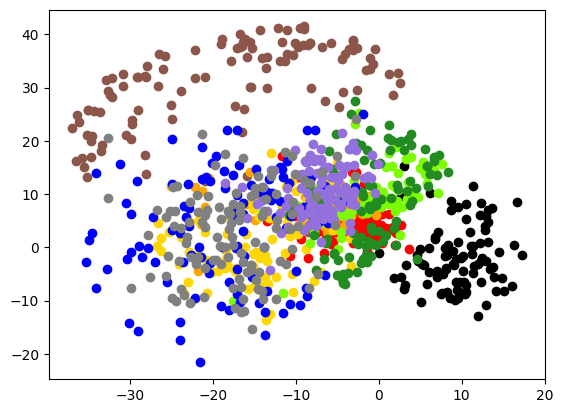

In [77]:
for i in range(10):
    class_indices = np.where(y_val == i)
    scatter = plt.scatter(h[class_indices,2], h[class_indices,0], color = colour_options[i], marker='o')
plt.show()

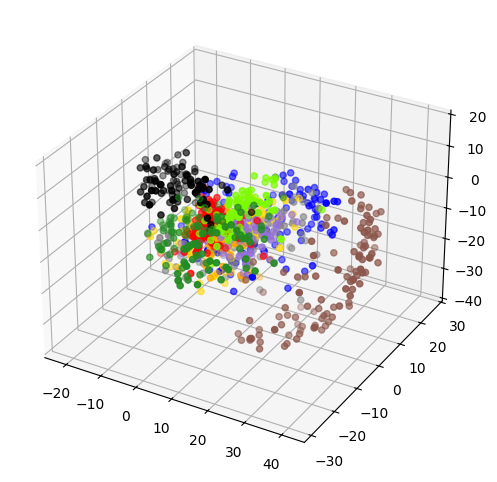

In [78]:
# Or you can plot a 3D scatter plot.
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(...)
#===== YOUR CODE HERE =====
# Plot the scatter points
for i in range(10):
    class_indices = np.where(y_val == i)
    scatter = ax.scatter(h[class_indices,0], h[class_indices,1], h[class_indices,2], color = colour_options[i], marker='o')
plt.show()



# Plot to Reconstruct the Images

Processing class 0, index 34
Input shape: torch.Size([1, 1, 28, 28])


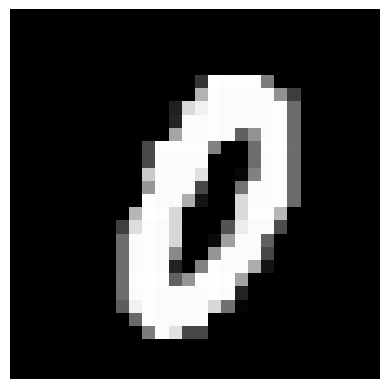

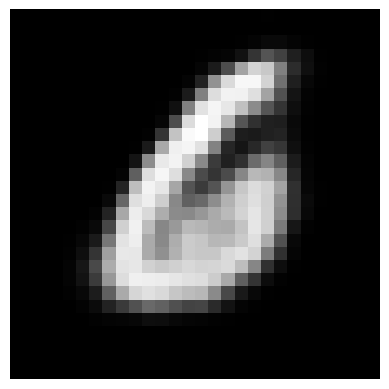

Processing class 1, index 8
Input shape: torch.Size([1, 1, 28, 28])


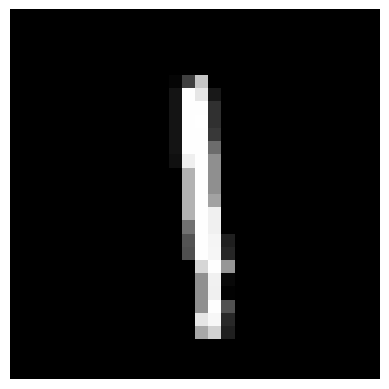

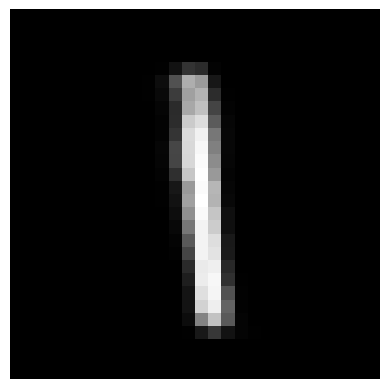

Processing class 2, index 5
Input shape: torch.Size([1, 1, 28, 28])


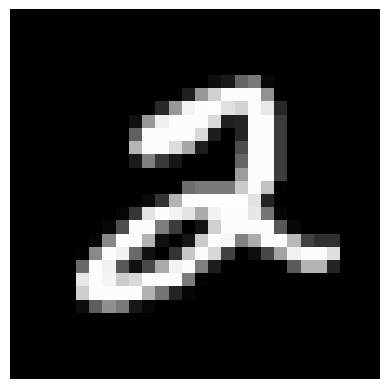

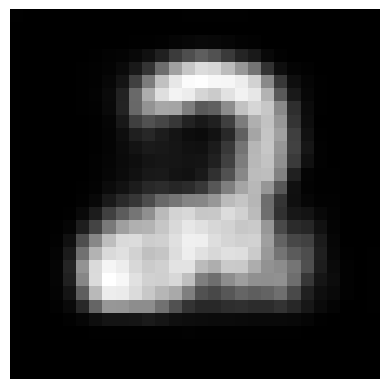

Processing class 3, index 3
Input shape: torch.Size([1, 1, 28, 28])


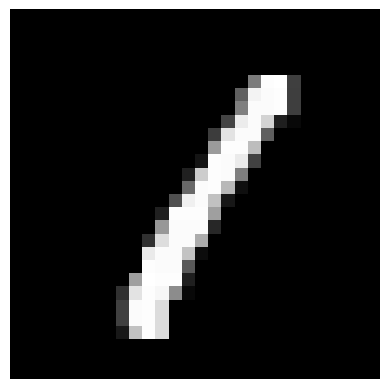

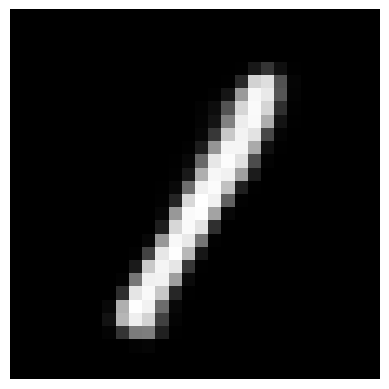

Processing class 4, index 0
Input shape: torch.Size([1, 1, 28, 28])


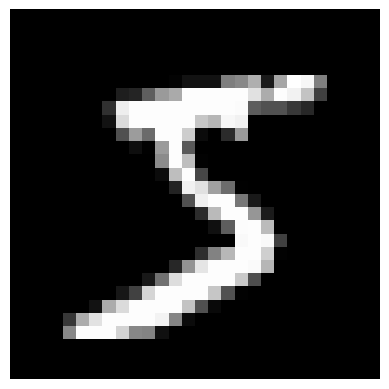

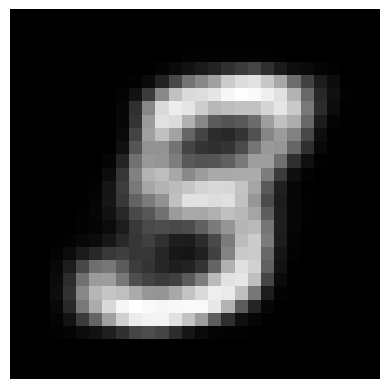

Processing class 5, index 13
Input shape: torch.Size([1, 1, 28, 28])


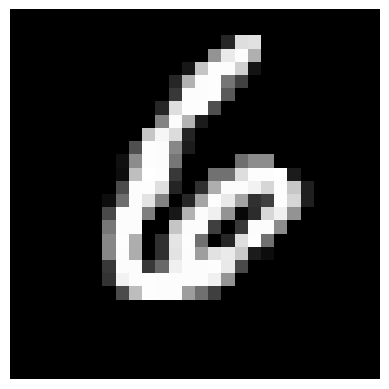

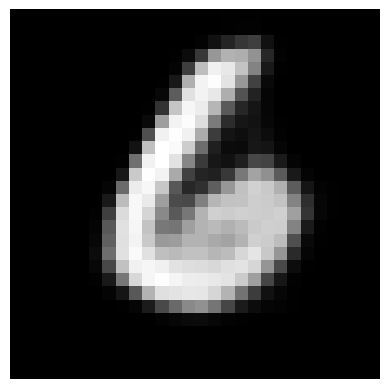

Processing class 6, index 17
Input shape: torch.Size([1, 1, 28, 28])


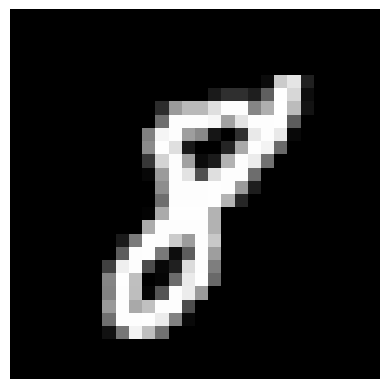

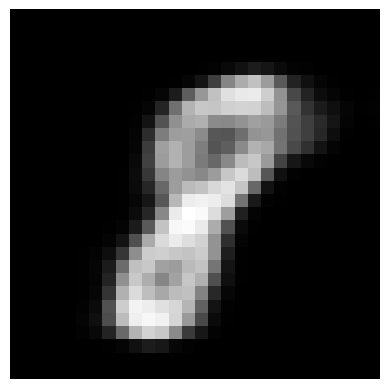

Processing class 7, index 7
Input shape: torch.Size([1, 1, 28, 28])


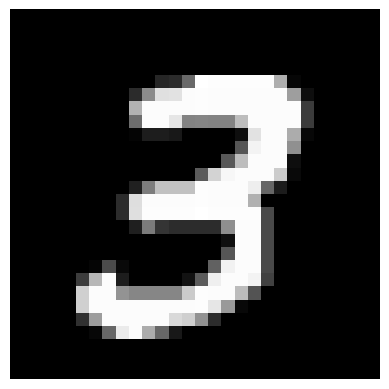

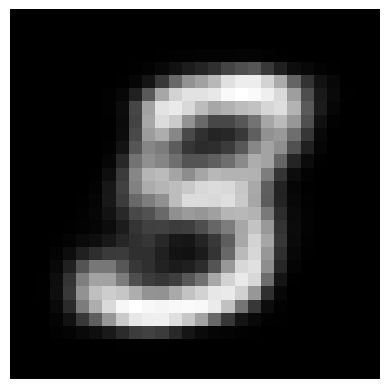

Processing class 8, index 1
Input shape: torch.Size([1, 1, 28, 28])


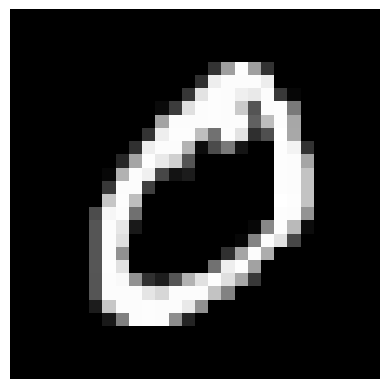

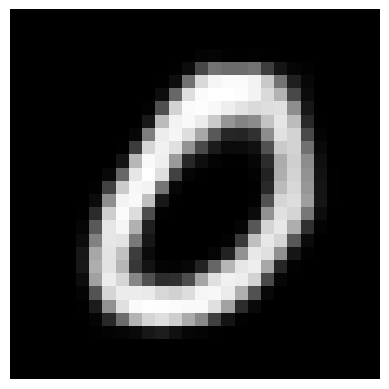

Processing class 9, index 4
Input shape: torch.Size([1, 1, 28, 28])


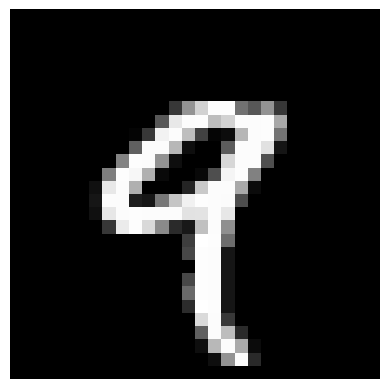

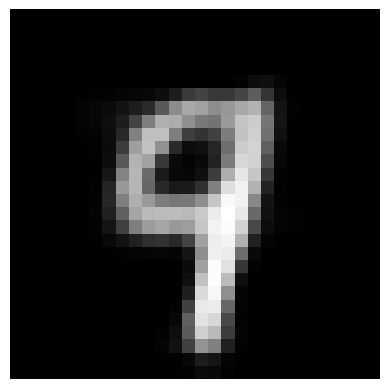

In [79]:
for i in range(10):
        class_indices = np.where(y_val == i)[0]
        if len(class_indices) == 0:
            print(f"Skipping class {i} (no samples)")
            continue
            
        print(f"Processing class {i}, index {class_indices[0]}")
        with torch.no_grad():
            x, t = ds[class_indices[0]] # Using dataset indexing directly
            # x from dataset might not have batch dim if using Subset? 
            # torchvision Subset returns (img, target). Img is 3D tensor (C,H,W)
            # network expects (B,C,H,W)
            x = x.unsqueeze(0) 
            
            print(f"Input shape: {x.shape}")
            Draw(x)
            plt.show()
            
            y_net = net(x)
            Draw(y_net)
            plt.show()


# Testing Model Accuracy

In [80]:
import sklearn


train_embeddings = []
train_labels = []
    
with torch.no_grad():
    for x, y in train_all:
        h = net.encode(x)
        train_embeddings.append(h)
        train_labels.append(y)
            
train_embeddings = torch.cat(train_embeddings)
train_labels = torch.cat(train_labels)

test_embeddings = []
test_labels = []
with torch.no_grad():
    for x, y in test_dl:
        h = net.encode(x)
        test_embeddings.append(h)
        test_labels.append(y)
    
test_embeddings = torch.cat(test_embeddings)
test_labels = torch.cat(test_labels)
    
# 1-NN implementation in Torch
# Distance matrix: (N_test, N_train)
# To avoid OOM, do it in batches or loops
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")
    
correct = 0
total = 0
    
# Process test set in chunks
chunk_size = 100
num_test = test_embeddings.size(0)

for k in range(1, 100):    
    for i in range(0, num_test, chunk_size):
        end = min(i + chunk_size, num_test)
        batch_emb = test_embeddings[i:end]
        batch_labels = test_labels[i:end]
        
        # batch_emb: (B, D), train_embeddings: (N, D)
        # cdist computes p-norm distance
        dists = torch.cdist(batch_emb, train_embeddings, p=2) 

        #print(dists)
        #print(dists.shape)
        #print(torch.min(dists, dim=1))
        # Get nearest neighbor indices
        # min over dim=1 (training samples)
        _, indices = torch.topk(dists, k, largest=False, sorted=True)
        #print(train_labels[indices])
        # Create predicted labels
        pred_labels = torch.max(train_labels[indices], dim=1).values
        #print(pred_labels)    
        correct += (pred_labels == batch_labels).sum().item()
        total += batch_labels.size(0)
    print(k)    
    accuracy = correct / total * 100
    print(f"k-NN Classification Accuracy using latent embeddings: {accuracy:.2f}%")

Train embeddings shape: torch.Size([4096, 3])
Test embeddings shape: torch.Size([10000, 3])
1
k-NN Classification Accuracy using latent embeddings: 65.73%
2
k-NN Classification Accuracy using latent embeddings: 65.59%
3
k-NN Classification Accuracy using latent embeddings: 64.79%
4
k-NN Classification Accuracy using latent embeddings: 64.02%
5
k-NN Classification Accuracy using latent embeddings: 63.27%
6
k-NN Classification Accuracy using latent embeddings: 62.57%
7
k-NN Classification Accuracy using latent embeddings: 61.93%
8
k-NN Classification Accuracy using latent embeddings: 61.33%
9
k-NN Classification Accuracy using latent embeddings: 60.78%
10
k-NN Classification Accuracy using latent embeddings: 60.27%
11
k-NN Classification Accuracy using latent embeddings: 59.79%
12
k-NN Classification Accuracy using latent embeddings: 59.32%
13
k-NN Classification Accuracy using latent embeddings: 58.88%
14
k-NN Classification Accuracy using latent embeddings: 58.46%
15
k-NN Classificatio